In [1]:
path = '/archive/shared/sim_center/shared/annie/levenshtein-scores/'
runs = ['claude_opus',
        'claude_sonnet',
        'gpt4_1chunk',
        'gpt4_3chunk_original',
        'gpt4_3chunk',
        'gpt4_original_6chunk',
        'gpt4_original_9chunk',
        'gpt35',
        'mixtral',
        'gpt4o']
nosum_runs = ['gpt4o-nosum',
'gpt4-3chunk-nosum']

In [2]:
import pandas as pd
import numpy as np

In [3]:
def extract_scores(path, run):
    id = []
    dist = []
    sim = []
    with open(path + run + '.txt', 'r') as file:
        lines = file.readlines()
    for line in lines:
        vals = line.replace('\n', '').split(',')
        id.append(vals[0].replace('ID: ', ''))
        dist.append(vals[1].replace('distance: ', ''))
        sim.append(vals[2].replace('similarity: ', ''))
    df = pd.DataFrame(np.column_stack([id, dist, sim]), 
                               columns=['ID', 'dist', 'sim'])
    return df

In [5]:
dfs = []
for run in runs + nosum_runs:
    df = extract_scores(path, run)
    df.insert(0, "run", [run]*10, True)
    dfs.append(df)


In [6]:
big_df = pd.DataFrame(pd.concat(dfs[i] for i in range(len(dfs))))


In [7]:
big_df

,run,ID,dist,sim
0,claude_opus,01_0542_298135,0.0708124652198108,0.9291875347801892
1,claude_opus,02_0036_174595,0.04935826334970686,0.9506417366502932
2,claude_opus,03_0028_174553,0.03803506962351728,0.9619649303764827
3,claude_opus,04_0043_174686,0.050453011192041215,0.9495469888079587
4,claude_opus,05_0033_174804,0.09898962315674495,0.901010376843255
...,...,...,...,...
5,gpt4-3chunk-nosum,06_0079_175106,0.029455709711846318,0.9705442902881537
6,gpt4-3chunk-nosum,07_0068_174641,0.041323330463657604,0.9586766695363425
7,gpt4-3chunk-nosum,08_0029_174576,0.2013260025873221,0.7986739974126779
8,gpt4-3chunk-nosum,09_0029_174582,0.037762501177135324,0.9622374988228647


In [8]:
big_df['sim'] = [float(i) for i in big_df['sim']]

In [9]:
mean_sim = big_df.groupby('run', as_index=False)['sim'].mean()

In [19]:
mean_sim[mean_sim['run']=='claude_opus']

,run,sim
0,claude_opus,0.938638


In [11]:
import matplotlib.pyplot as plt

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'claude_opus'),
  Text(1, 0, 'claude_sonnet'),
  Text(2, 0, 'gpt35'),
  Text(3, 0, 'gpt4-3chunk-nosum'),
  Text(4, 0, 'gpt4_1chunk'),
  Text(5, 0, 'gpt4_3chunk'),
  Text(6, 0, 'gpt4_3chunk_original'),
  Text(7, 0, 'gpt4_original_6chunk'),
  Text(8, 0, 'gpt4_original_9chunk'),
  Text(9, 0, 'gpt4o'),
  Text(10, 0, 'gpt4o-nosum'),
  Text(11, 0, 'mixtral')])

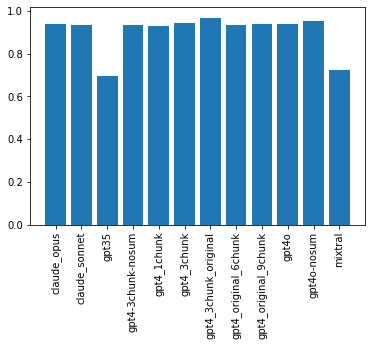

In [12]:
plt.bar(mean_sim['run'], mean_sim['sim'])
plt.xticks(rotation='vertical')

([0, 1, 2, 3],
 [Text(0, 0, 'gpt4-3chunk-nosum'),
  Text(1, 0, 'gpt4_3chunk'),
  Text(2, 0, 'gpt4o'),
  Text(3, 0, 'gpt4o-nosum')])

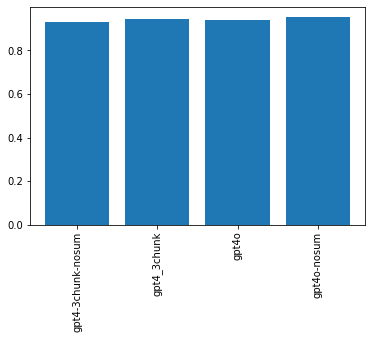

In [28]:
x = [mean_sim.iloc[3]['run'], mean_sim.iloc[5]['run'], mean_sim.iloc[9]['run'], mean_sim.iloc[10]['run']] 
y = [mean_sim.iloc[3]['sim'], mean_sim.iloc[5]['sim'], mean_sim.iloc[9]['sim'], mean_sim.iloc[10]['sim']] 
plt.bar(x, y)
plt.xticks(rotation='vertical')

In [27]:
mean_sim.iloc[3]['run']

'gpt4-3chunk-nosum'

In [12]:
def read_transcript_from_id(transcript_id):

    path_to_data_folder = '/archive/shared/sim_center/shared/ameer/'
    # lookinto this dictionary to find the path
    # can also manually create the path and it would be faster but not by much
    merged_lookup = pd.read_csv(path_to_data_folder + 'grade_lookupv5.csv')
    transcript = ''

    path = merged_lookup[merged_lookup.id == transcript_id].path.iloc[0]
    with open(path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        if line != '\n':
            tok_line = line.split(' ')
            for i in range(len(tok_line)):
                transcript += ' ' + tok_line[i]


    return transcript

In [13]:
def reconstruct_transcript(path, id): 
    path = path + id + '.txt'
    with open(path, 'r') as file:
        lines = file.readlines()
 
    out = []
    
    for line in lines:
        if line.find(':')==-1: continue
        temp = {}
        temp['speaker'] = line[:line.find(':')]
        temp['text'] = line[line.find(':') + 1: ]
        out.append(temp)

    return out

In [14]:
def consolidate_transcript(transcript):
    
    new = []
    new.append({'speaker': transcript[0]['speaker'], 'text': transcript[0]['text']})
    
    for i in range(1, len(transcript)):
        this = {}
        if transcript[i]['speaker'] == transcript[i-1]['speaker']:
            new[-1]['text'] += transcript[i]['text']
        else:
            this['speaker'] = transcript[i]['speaker']
            this['text'] = transcript[i]['text']
            new.append(this)
    
    return new

In [15]:
def extract_text(transcript):
    out = ''
    for line in transcript:
        out += line['speaker'] + line['text']
    return out

In [16]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
normalized_levenshtein = NormalizedLevenshtein()

In [17]:
def eval_transcript(ids, diar_path='/archive/shared/sim_center/shared/annie/GPT4 3-chunk/', 
                    gold_path = '/archive/shared/sim_center/shared/annie/gpt4-gold-standard-diarized/'):
    scores = {}
    for id in ids:
        # debugging statement: 
        print(id) 
        diar = extract_text(consolidate_transcript(reconstruct_transcript(diar_path, id)))
        gold = extract_text(consolidate_transcript(reconstruct_transcript(gold_path, id)))
        distance = normalized_levenshtein.distance(diar, gold)
        similarity = normalized_levenshtein.similarity(diar, gold)
        scores[id] = [distance, similarity]
    return scores

In [18]:
ids = big_df['ID'].unique()

In [19]:
ids

array(['01_0542_298135', '02_0036_174595', '03_0028_174553',
       '04_0043_174686', '05_0033_174804', '06_0079_175106',
       '07_0068_174641', '08_0029_174576', '09_0029_174582',
       '10_0991_331330'], dtype=object)

In [20]:
def nolabel_baseline_score(ids, gold_path = '/archive/shared/sim_center/shared/annie/gpt4-gold-standard-diarized/'):
    scores = {}
    for id in ids:
        # debugging statement: 
        print(id) 
        transcript = read_transcript_from_id(id)
        gold = extract_text(consolidate_transcript(reconstruct_transcript(gold_path, id)))
        distance = normalized_levenshtein.distance(transcript, gold)
        similarity = normalized_levenshtein.similarity(transcript, gold)
        scores[id] = [distance, similarity]
    return scores

In [21]:
def save_scores(scores, ids, path = '/archive/shared/sim_center/shared/annie/levenshtein-scores/', run_name = 'gpt4'):
    with open(path + run_name + ".txt", "w") as outfile:
        for id in ids:
            outfile.write('ID: ' + id + ', distance: ' + str(scores[id][0]) + ', similarity: ' + str(scores[id][1]) + '\n')

In [22]:
nolabel_baseline = extract_scores(path, 'nolabel_baseline')

In [23]:
nolabel_baseline

,ID,dist,sim
0,01_0542_298135,0.0973305954825462,0.9026694045174538
1,02_0036_174595,0.11123400221203981,0.8887659977879602
2,03_0028_174553,0.10042652190771617,0.8995734780922838
3,04_0043_174686,0.10987742050097708,0.890122579499023
4,05_0033_174804,0.1151010376843255,0.8848989623156744
5,06_0079_175106,0.12497331910352188,0.8750266808964782
6,07_0068_174641,0.1582831140081171,0.8417168859918829
7,08_0029_174576,0.11222509702457956,0.8877749029754205
8,09_0029_174582,0.12082116960165741,0.8791788303983425
9,10_0991_331330,0.13156665888395985,0.8684333411160401


In [24]:
big_df

,run,ID,dist,sim
0,claude_opus,01_0542_298135,0.0708124652198108,0.929188
1,claude_opus,02_0036_174595,0.04935826334970686,0.950642
2,claude_opus,03_0028_174553,0.03803506962351728,0.961965
3,claude_opus,04_0043_174686,0.050453011192041215,0.949547
4,claude_opus,05_0033_174804,0.09898962315674495,0.901010
...,...,...,...,...
5,gpt4o,06_0079_175106,0.07406616862326575,0.925934
6,gpt4o,07_0068_174641,0.04814189189189189,0.951858
7,gpt4o,08_0029_174576,0.0842496765847348,0.915750
8,gpt4o,09_0029_174582,0.05198229588473491,0.948018


In [29]:
#big_df['baseline'] = [0]*len(big_df)
baseline = []
for id in big_df['ID']:
    baseline.append(float(nolabel_baseline[nolabel_baseline['ID']==id]['sim']))
big_df['baseline'] = baseline


<ipython-input-29-b9f1b955c644>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  baseline.append(float(nolabel_baseline[nolabel_baseline['ID']==id]['sim']))


In [30]:
big_df

,run,ID,dist,sim,baseline
0,claude_opus,01_0542_298135,0.0708124652198108,0.929188,0.902669
1,claude_opus,02_0036_174595,0.04935826334970686,0.950642,0.888766
2,claude_opus,03_0028_174553,0.03803506962351728,0.961965,0.899573
3,claude_opus,04_0043_174686,0.050453011192041215,0.949547,0.890123
4,claude_opus,05_0033_174804,0.09898962315674495,0.901010,0.884899
...,...,...,...,...,...
5,gpt4o,06_0079_175106,0.07406616862326575,0.925934,0.875027
6,gpt4o,07_0068_174641,0.04814189189189189,0.951858,0.841717
7,gpt4o,08_0029_174576,0.0842496765847348,0.915750,0.887775
8,gpt4o,09_0029_174582,0.05198229588473491,0.948018,0.879179


In [31]:
# calculate the rough normalized score
big_df['baseline_norm_sim'] = (big_df['sim']-big_df['baseline'])/(1-big_df['baseline'])

In [32]:
big_df

,run,ID,dist,sim,baseline,baseline_norm_sim
0,claude_opus,01_0542_298135,0.0708124652198108,0.929188,0.902669,0.272454
1,claude_opus,02_0036_174595,0.04935826334970686,0.950642,0.888766,0.556266
2,claude_opus,03_0028_174553,0.03803506962351728,0.961965,0.899573,0.621265
3,claude_opus,04_0043_174686,0.050453011192041215,0.949547,0.890123,0.540825
4,claude_opus,05_0033_174804,0.09898962315674495,0.901010,0.884899,0.139976
...,...,...,...,...,...,...
5,gpt4o,06_0079_175106,0.07406616862326575,0.925934,0.875027,0.407344
6,gpt4o,07_0068_174641,0.04814189189189189,0.951858,0.841717,0.695849
7,gpt4o,08_0029_174576,0.0842496765847348,0.915750,0.887775,0.249280
8,gpt4o,09_0029_174582,0.05198229588473491,0.948018,0.879179,0.569758


In [33]:
mean_norm_sim = big_df.groupby(['run'], as_index=False)['baseline_norm_sim'].mean()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'claude_opus'),
  Text(1, 0, 'claude_sonnet'),
  Text(2, 0, 'gpt35'),
  Text(3, 0, 'gpt4_1chunk'),
  Text(4, 0, 'gpt4_3chunk'),
  Text(5, 0, 'gpt4_3chunk_original'),
  Text(6, 0, 'gpt4_original_6chunk'),
  Text(7, 0, 'gpt4_original_9chunk'),
  Text(8, 0, 'gpt4o'),
  Text(9, 0, 'mixtral')])

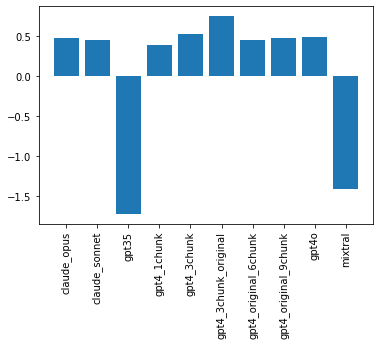

In [34]:
plt.bar(mean_norm_sim['run'], mean_norm_sim['baseline_norm_sim'])
plt.xticks(rotation='vertical')

In [35]:
def opposite_transcript(transcript):

    def opposite(speaker):
        if speaker=='Student': return 'Patient'
        elif speaker=='Patient': return 'Student'
        return 'Student'
    
    new = []
    new.append({'speaker': opposite(transcript[0]['speaker']), 'text': transcript[0]['text']})
    
    for i in range(1, len(transcript)):
        this = {}
        if transcript[i]['speaker'] == transcript[i-1]['speaker']:
            new[-1]['text'] += transcript[i]['text']
        else:
            this['speaker'] = opposite(transcript[i]['speaker'])
            this['text'] = transcript[i]['text']
            new.append(this)
    
    return new

In [39]:
def opposite_baseline_score(ids, gold_path = '/archive/shared/sim_center/shared/annie/gpt4-gold-standard-diarized/'):
    scores = {}
    for id in ids:
        # debugging statement: 
        print(id) 
        transcript = extract_text(opposite_transcript(reconstruct_transcript(gold_path, id)))
        gold = extract_text(consolidate_transcript(reconstruct_transcript(gold_path, id)))
        distance = normalized_levenshtein.distance(transcript, gold)
        similarity = normalized_levenshtein.similarity(transcript, gold)
        scores[id] = [distance, similarity]
    return scores


In [40]:
opposite = opposite_baseline_score(ids)

01_0542_298135
02_0036_174595
03_0028_174553
04_0043_174686
05_0033_174804
06_0079_175106
07_0068_174641
08_0029_174576
09_0029_174582
10_0991_331330


TypeError: save_scores() missing 1 required positional argument: 'ids'

In [41]:
save_scores(opposite, ids, run_name='opposite_baseline')

In [46]:
opposite_baseline = extract_scores(path, 'opposite_baseline')

In [47]:
#big_df['baseline'] = [0]*len(big_df)
opp = []
for id in big_df['ID']:
    opp.append(float(opposite_baseline[opposite_baseline['ID']==id]['sim']))
big_df['opposite_baseline'] = opp

<ipython-input-47-79645b6aad11>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opp.append(float(opposite_baseline[opposite_baseline['ID']==id]['sim']))


In [49]:
big_df['opposite_norm_sim'] = (big_df['sim']-big_df['opposite_baseline'])/(1-big_df['opposite_baseline'])

In [50]:
mean_opp_sim = big_df.groupby(['run'], as_index=False)['opposite_norm_sim'].mean()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'claude_opus'),
  Text(1, 0, 'claude_sonnet'),
  Text(2, 0, 'gpt35'),
  Text(3, 0, 'gpt4_1chunk'),
  Text(4, 0, 'gpt4_3chunk'),
  Text(5, 0, 'gpt4_3chunk_original'),
  Text(6, 0, 'gpt4_original_6chunk'),
  Text(7, 0, 'gpt4_original_9chunk'),
  Text(8, 0, 'gpt4o'),
  Text(9, 0, 'mixtral')])

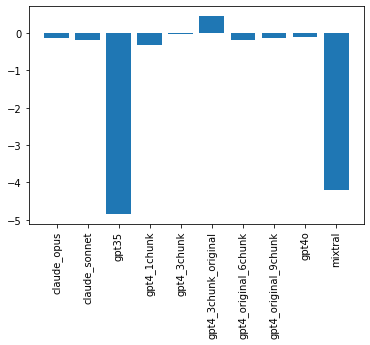

In [52]:
plt.bar(mean_opp_sim['run'], mean_opp_sim['opposite_norm_sim'])
plt.xticks(rotation='vertical')

In [54]:
big_df.to_csv('/archive/shared/sim_center/shared/annie/levenshtein-scores/big_df.csv')